---

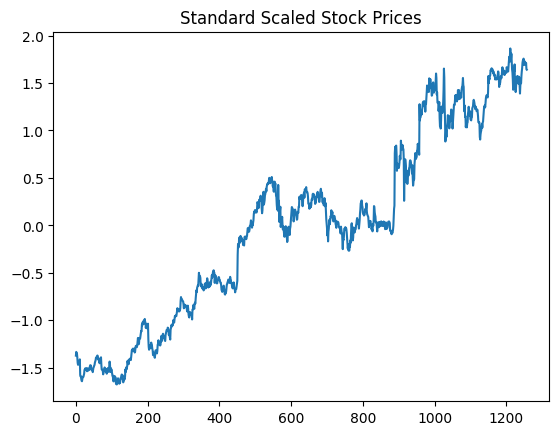

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch [100/300], Training Loss: 0.0031, Validation Loss: 0.0049886382184922695
Epoch [200/300], Training Loss: 0.0033, Validation Loss: 0.004256714601069689
Epoch [300/300], Training Loss: 0.0031, Validation Loss: 0.004475326742976904


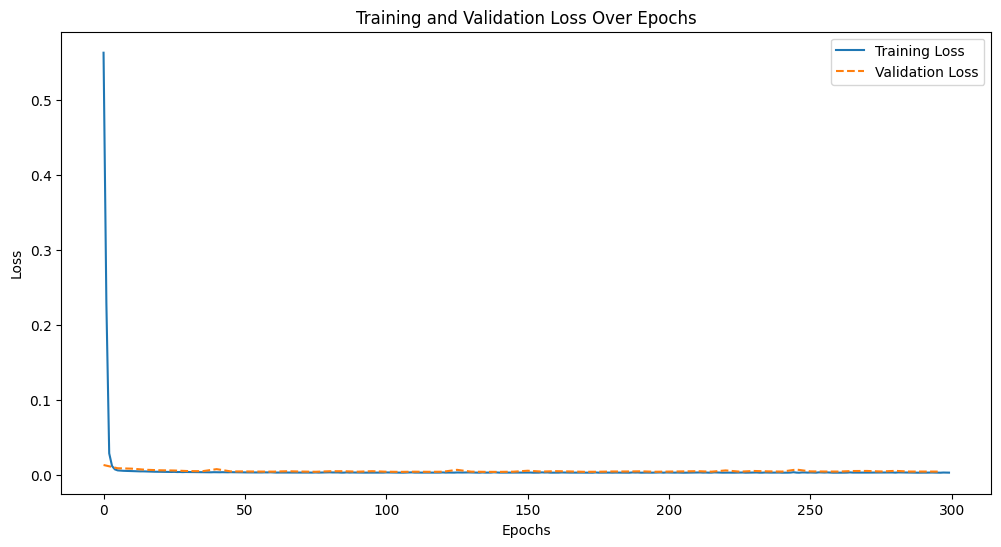

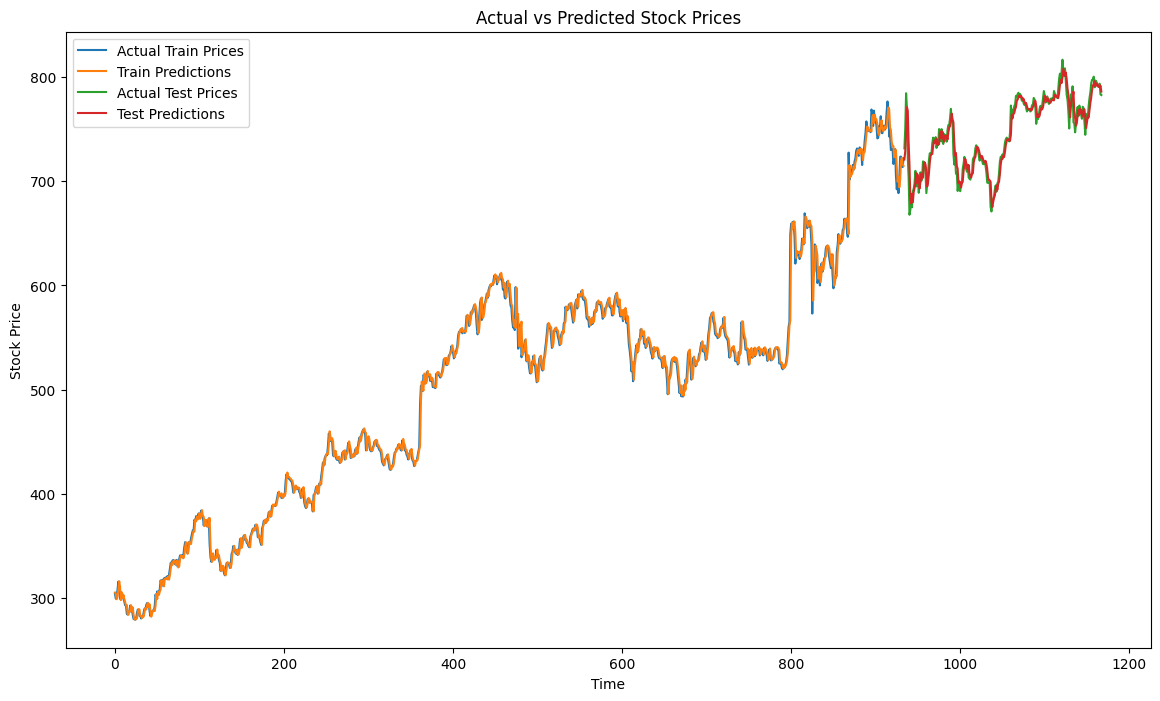

Training RMSE: 8.32
Testing RMSE: 10.16


In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data
data = pd.read_csv('/content/Google_Stock_Price_Train-1.csv')

# Select the 'Open' price and scale it
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Open']].values)

# Visualize data (optional)
plt.plot(data_scaled)
plt.title('Standard Scaled Stock Prices')
plt.show()

sequence_length = 90

# Create sequences and labels
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split data into training (80%) and testing (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

# Define a modified GRU-based model
class StockPriceGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, num_layers=1, dropout=0.3):
        super(StockPriceGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        x = self.fc1(gru_out[:, -1, :])
        return self.fc2(x)

# Initialize the model, loss function, and optimizer
model = StockPriceGRU().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Changed batch size

# Training loop with custom loss tracking
epochs = 300
train_losses = []
val_losses = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate validation loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_test)
            val_loss = criterion(val_predictions, y_test)
        val_losses.append(val_loss.item())
        model.train()

    # Record the average training loss for this epoch
    train_losses.append(epoch_loss / len(train_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss/len(train_loader):.4f}, Validation Loss: {val_loss.item() if (epoch + 1) % 5 == 0 else 'N/A'}")

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
if val_losses:
    plt.plot([i * 5 for i in range(len(val_losses))], val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Predictions
model.eval()
with torch.no_grad():
    train_predictions = model(X_train).cpu().numpy()
    test_predictions = model(X_test).cpu().numpy()

    # Inverse transform predictions to get actual stock prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    actual_train = scaler.inverse_transform(y_train.cpu().numpy())
    actual_test = scaler.inverse_transform(y_test.cpu().numpy())

# Plot actual and predicted stock prices
plt.figure(figsize=(14, 8))
plt.plot(actual_train, label='Actual Train Prices')
plt.plot(train_predictions, label='Train Predictions')
plt.plot(range(len(actual_train), len(actual_train) + len(actual_test)), actual_test, label='Actual Test Prices')
plt.plot(range(len(actual_train), len(actual_train) + len(test_predictions)), test_predictions, label='Test Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Calculate RMSE for training and testing predictions
train_rmse = np.sqrt(np.mean((train_predictions - actual_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predictions - actual_test) ** 2))

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
